In [10]:
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

PATH_IMG = "../IMAGENS/"

PATH = os.getcwd()

print(os.getcwd())
print(os.listdir(PATH_IMG))
print(cv.__version__)

img_original = cv.imread(PATH_IMG + os.listdir(PATH_IMG)[1])
img_gray = cv.cvtColor(img_original, cv.COLOR_BGR2GRAY)

/home/andre/Documents/Git/VISAO_ROBOTICA_EGM0008/06_DETECCAO_CANNY
['circulo.png', 'Lenna.png', 'carrinho.jpg', 'Einstein.png', 'everest.jpg', 'fabio.png']
4.10.0


In [ ]:
#=======================================================================
def cm_to_inch(value):
    return value/2.54
#=======================================================================
def filtro_espacial(img, kernel):
    img_temp = np.zeros_like(img, dtype=np.float32)

    lk = kernel.shape[0]
    ck = kernel.shape[1]

    llin = int(lk/2)
    lcol = int(ck/2)

    res = 0
    for i in range(llin, img.shape[0] - llin):
        for j in range(lcol, img.shape[1] - lcol):
            janela = img[(i-llin):(i+llin+1), (j-lcol):(j+lcol+1)]
            res = janela * kernel

            img_temp[i,j] = np.sum(res)

    return img_temp
#=======================================================================
def gaussian_kernel(size, k, sigma):
    kernel = np.zeros((size,size))
    
    llin = int(size/2) #supoe impar
    lcol = llin #e quadrado
    
    for m in range(-llin, llin+1):
        for n in range(-lcol, lcol+1):
            kernel[m+llin, n+lcol] = k*np.exp(-(m**2+n**2) / (2*sigma**2))
    
    kernel = 1 / np.sum(kernel) * kernel 
    
    return kernel
#=======================================================================
def CannyPessoal(img, t1, t2):
    
    # Kernel Sobel para X
    Sx = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
    ])

    # Kernel Sobel para Y
    Sy = Sx.transpose()

    try:
        if img.shape[2] > 1:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    except:
        pass
    # O sistema de coordenadas das imagens é o eixo Vertical como Y
    # (crescente de cima para baixo) e o eixo horizontal como X
    # (crescente da esquerda para direita)
    img_sobel_x = filtro_espacial(img, Sx)
    img_sobel_y = filtro_espacial(img, Sy)
    
    img_sobel_magnitude = np.sqrt(img_sobel_y**2 + img_sobel_x**2)

    img_gradiente = np.arctan2(img_sobel_y, img_sobel_x) 
    img_gradiente = np.rad2deg(img_gradiente)
    
    # No max surpression
    # Código com base no de Levi e Jose Igo
    img2 = img_sobel_magnitude.copy()

    # Supressão de não máximos: mantém apenas os valores máximos locais
    for i in range(1, img_gradiente.shape[0] - 1):
        for j in range(1, img_gradiente.shape[1] - 1):
            if img2[i, j] > 0:  # Se o pixel tiver um valor de gradiente significativo
                theta = img_gradiente[i, j]  # Obtém a direção do gradiente
                
                # Determina a orientação e compara com os vizinhos apropriados
                if 0 <= theta <= 22.5 or 157.5 <= theta <= 180:
                    if img2[i, j] <= max(img2[i-1, j], img2[i+1, j]):
                        img2[i, j] = 0  # Zera o pixel se não for máximo local
                elif 22.5 < theta <= 67.5:
                    if img2[i, j] <= max(img2[i-1, j-1], img2[i+1, j+1]):
                        img2[i, j] = 0
                elif 67.5 < theta <= 112.5:
                    if img2[i, j] <= max(img2[i, j-1], img2[i, j+1]):
                        img2[i, j] = 0
                elif 112.5 < theta < 157.5:
                    if img2[i, j] <= max(img2[i+1, j-1], img2[i-1, j+1]):
                        img2[i, j] = 0

    nms_img = img2.copy()  # Imagem após a supressão de não máximos
    
    # Aplicação de limiares duplos
    img_thr = np.zeros_like(nms_img)
    img_thr[nms_img >= t2] = 255  # Marca bordas fortes
    img_thr[(nms_img < t2) & (nms_img >= t1)] = 128  # Marca bordas fracas
    img_thr[nms_img < t1] = 0  # Descarta gradientes muito baixos

    # Realiza a histerese para conectar bordas
    img_hist = img_thr.copy()
    changed = True

    while changed:  # Continua enquanto houver mudanças na imagem
        changed = False
        img_copy = img_hist.copy()

        # Conecta bordas fracas a bordas fortes
        for i in range(1, img_hist.shape[0] - 1):
            for j in range(1, img_hist.shape[1] - 1):
                if img_hist[i, j] == 128:  # Verifica bordas fracas
                    I_r = img_hist[i - 1:i + 2, j - 1:j + 2]  # Vizinhança 3x3
                    if (I_r == 255).any():  # Se houver borda forte próxima
                        img_copy[i, j] = 255  # Converte em borda forte
                        changed = True

        img_hist = img_copy.copy()  # Atualiza a imagem

    # Remove bordas fracas restantes
    img_hist[img_hist == 128] = 0
    
    return np.uint8(img_hist)

# Detecção de bordas com Canny

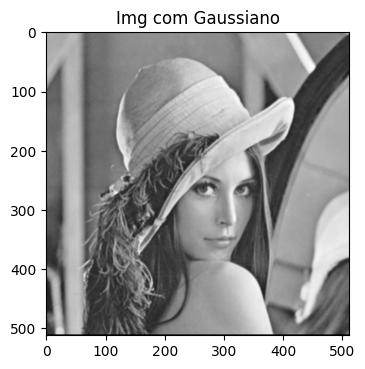

In [12]:
kernel_gaussian = gaussian_kernel(3,1,1)

img_gaussian = filtro_espacial(img_gray, kernel_gaussian)

figure(figsize=(cm_to_inch(10), cm_to_inch(10)))
plt.imshow(img_gaussian, cmap="gray")
plt.title("Img com Gaussiano")

plt.show()

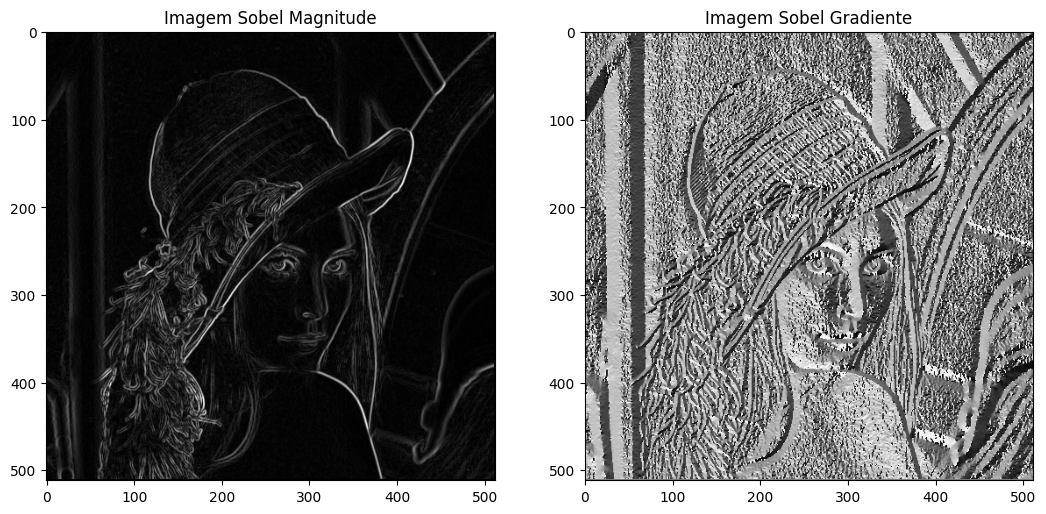

In [13]:
Sx = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

Sy = Sx.transpose()

img_sobel_horizontal = filtro_espacial(img_gray, Sx)
img_sobel_vertical = filtro_espacial(img_gray, Sy)

# img_sobel_horizontal = cv.normalize(img_sobel_horizontal, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
# img_sobel_vertical = cv.normalize(img_sobel_vertical, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

img_sobel_magnitude = np.sqrt(img_sobel_horizontal**2 + img_sobel_vertical**2)

img_gradiente = np.arctan2(img_sobel_vertical, img_sobel_horizontal) 
img_gradiente = np.rad2deg(img_gradiente)

plt.figure(figsize=(cm_to_inch(50), cm_to_inch(50)))

plt.subplot(131)
plt.title("Imagem Sobel Magnitude")
plt.imshow(img_sobel_magnitude, cmap='gray')

plt.subplot(132)
plt.title("Imagem Sobel Gradiente")
plt.imshow(img_gradiente, cmap='gray')

plt.show()

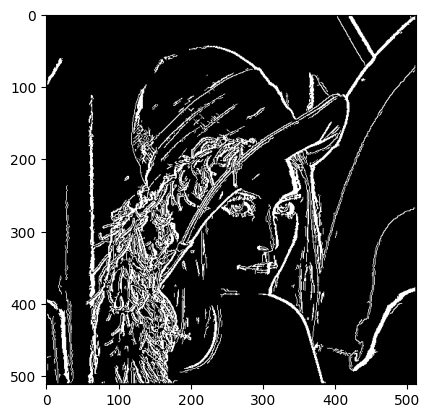

In [29]:
img_canny = CannyPessoal(img_gray, 70, 120)
plt.imshow(img_canny, cmap='gray')
plt.show()